Load Data

In [ ]:
# Import all possible libraries that are needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import email
import re
import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import coo_matrix, hstack

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# considering the run-time, we only read the first 500 rows here
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emails.csv")
enron = df.copy()

In [ ]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
df.describe()

,file,message
count,517401,517401
unique,517401,517401
top,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
freq,1,1


In [ ]:
email_sent = df[df["file"].str.contains('sent').tolist()]

In [ ]:
email_sent = email_sent.assign(sender=email_sent["file"].map(lambda x: re.search("(.*)/.*sent", x).group(1)).values)
email_sent.drop("file", axis=1, inplace=True)
email_sent["sender"].value_counts().head(15)

mann-k           8926
kaminski-v       8644
dasovich-j       5366
germany-c        5128
shackleton-s     4407
jones-t          4123
bass-e           3030
lenhart-m        2759
beck-s           2674
symes-k          2649
scott-s          2602
taylor-m         2409
love-p           2371
arnold-j         2353
perlingiere-d    2352
Name: sender, dtype: int64

In [ ]:
all_sender = email_sent["sender"].value_counts(normalize=False, sort=False)
all_sender

allen-p        1509
arnold-j       2353
arora-h          78
badeer-r         59
bailey-s         14
               ... 
williams-w3     519
wolfe-j          93
ybarbo-p        130
zipper-a        350
zufferli-j      338
Name: sender, Length: 154, dtype: int64

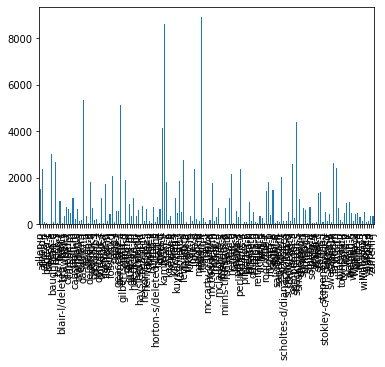

In [ ]:
all_sender.plot.bar(ylim=0)
plt.show()

In [ ]:
# mapping top senders' names to use later as label series
# we work only with top 15 senders

top_senders = email_sent["sender"].value_counts().head(15).index.values
mapping = dict(zip(top_senders, range(15)))

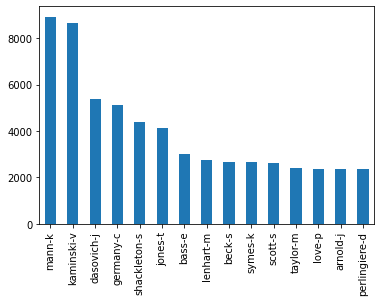

In [ ]:
(email_sent["sender"].value_counts().head(15)).plot.bar(ylim=0)
plt.show()

Extract Raw Text

In [ ]:
# extract headings
# From
# To
# ...
def raw_process(raw_data):
    body = email.message_from_string(raw_data)
    
    content = []
    # extract the useful info for headings
    for part in body.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
            
    result = {}
    for key in body.keys(): 
        result[key] = body[key]
    result["content"] = ''.join(content)
    
    return result

In [ ]:
# extract text body from raw text
email_parsed = pd.DataFrame(list(map(raw_process, email_sent.message)))
# extract the user from file
#email_parsed['user'] = email_parsed['file'].map(lambda x: x.split('/')[0])
email_parsed.head(1)

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,NaN,NaN


In [ ]:
email_parsed.dtypes

Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
content                      object
Cc                           object
Bcc                          object
dtype: object

In [ ]:
email_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126846 entries, 0 to 126845
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Message-ID                 126846 non-null  object
 1   Date                       126846 non-null  object
 2   From                       126846 non-null  object
 3   To                         126472 non-null  object
 4   Subject                    126846 non-null  object
 5   Mime-Version               126846 non-null  object
 6   Content-Type               126846 non-null  object
 7   Content-Transfer-Encoding  126846 non-null  object
 8   X-From                     126846 non-null  object
 9   X-To                       126846 non-null  object
 10  X-cc                       126846 non-null  object
 11  X-bcc                      126846 non-null  object
 12  X-Folder                   126846 non-null  object
 13  X-Origin                   126846 non-null  

In [ ]:
# To construct a better text matrix we will remove numbers and stop words defined by nltk stopwords corpus

def after_nltk( content, remove_stopwords=False ):
    content = re.sub("[^a-zA-Z]"," ", content)
    words = content.lower().split()
    #basic text processing from CS506
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return ' '.join(words)

In [ ]:
# Build the main data frame, consist of subject and content as those are the main text filed for us to analyze
data = pd.DataFrame(list(map(after_nltk, 
                          email_parsed[['Subject', 'content']].apply(lambda x: ' '.join(x), axis=1))), 
                          columns = ["content"])

In [ ]:
# let's see how's the data look like
data.head()

,content
0,here is our forecast
1,re traveling to have a business meeting takes ...
2,re test test successful way to go
3,randy can you send me a schedule of the salary...
4,re hello let s shoot for tuesday at


In [ ]:
# we now map the dataframe with sender list therefore we can train the data and analyze email's sender
data = data.assign(sender=email_sent["sender"].values)
data = data.replace({'sender': mapping})
data.head()

,content,sender
0,here is our forecast,allen-p
1,re traveling to have a business meeting takes ...,allen-p
2,re test test successful way to go,allen-p
3,randy can you send me a schedule of the salary...,allen-p
4,re hello let s shoot for tuesday at,allen-p


In [ ]:
# train test split library gives unexpected integer output, therefore implementing split algo by myself
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(len(data)):
  s = np.random.uniform(0,1)
  #print(s)
  if s >= 0.3:
    x_train.append(data.content[i])
    y_train.append(data.sender[i])
  else:
    x_test.append(data.content[i])
    y_test.append(data.sender[i])

In [ ]:
len(x_train)

88804

In [ ]:
len(x_test)

38042

In [ ]:
len(y_train)

88804

Starting from here we finished data processing and move on to model fitting, the first model we choose is Naive Bayes model

In [ ]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(x_train, y_train)
# Predict the categories of the test data
predicted_senders = model.predict(x_test)

In [ ]:
#calculate the accuracy
print("The accuracy is {}".format(accuracy_score(y_test, predicted_senders)))

The accuracy is 0.3073445139582567


In [ ]:
print(classification_report(y_test, predicted_senders))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                        0       0.17      0.99      0.29      2710
                        1       0.18      0.99      0.31      2568
                       10       0.90      0.02      0.05       783
                       11       1.00      0.01      0.01       741
                       12       0.91      0.17      0.29       722
                       13       0.92      0.07      0.13       693
                       14       0.98      0.75      0.85       680
                        2       0.66      0.78      0.72      1643
                        3       0.71      0.73      0.72      1526
                        4       0.75      0.67      0.71      1339
                        5       0.83      0.51      0.63      1253
                        6       0.88      0.37      0.52       924
                        7       0.94      0.15      0.26       792
                        8       0.86      0.14      0.24     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Next we fit the parameters for linear SVM

In [ ]:
# Since it's text data we will vectorize our content
#from sklearn.feature_extraction.text import CountVectorizer
vector = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vector.fit_transform(x_train)
X_test = vector.transform(x_test)

In [ ]:
tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_pca, y_train)

print(metrics.accuracy_score(y_test, clf.predict(X_test_pca)))

0.698885442405762


In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':clf.predict(X_test_pca)})
df

,Actual,Predicted
0,allen-p,mcconnell-m
1,allen-p,allen-p
2,allen-p,nemec-g
3,allen-p,3
4,allen-p,allen-p
...,...,...
38037,zufferli-j,derrick-j
38038,zufferli-j,lavorato-j
38039,zufferli-j,white-s
38040,zufferli-j,13


In [ ]:
print(classification_report(y_test, clf.predict(X_test_pca)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                        0       0.90      0.93      0.91      2710
                        1       0.83      0.98      0.90      2568
                       10       0.52      0.67      0.58       783
                       11       0.61      0.62      0.61       741
                       12       0.83      0.89      0.86       722
                       13       0.57      0.73      0.64       693
                       14       0.91      0.93      0.92       680
                        2       0.70      0.90      0.78      1643
                        3       0.64      0.82      0.72      1526
                        4       0.90      0.91      0.91      1339
                        5       0.72      0.84      0.77      1253
                        6       0.69      0.82      0.75       924
                        7       0.38      0.77      0.51       792
                        8       0.82      0.94      0.87     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
